# $P(E_{\rm{det}} | E)$

Figuring out the implementation in Stan.

In [9]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
import stan_utility

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load input from cascade_model

In [10]:
from energy_conditional import EnergyConditional

In [11]:
cond_file = ('data/conditional_2D_nue_CC_simulation_'
             +'gamma_1.0_lEmin_3.0_lEmax_7.0_fixed.txt')
energy_conditional = EnergyConditional(cond_file)
pdf_spline = energy_conditional.spline

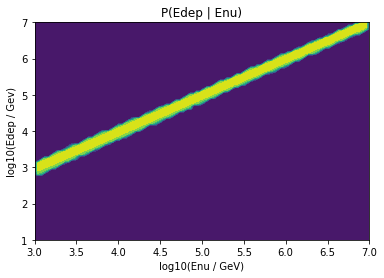

In [12]:
log10_Enu = np.linspace(3.0, 7.0, 100)
log10_Edep = np.linspace(1.0, 7.0, 100)

spline_val = np.zeros((100, 100))
for i, Enu in enumerate(log10_Enu):
    for j, Edep in enumerate(log10_Edep):
        spline_val[i][j] = pdf_spline(Enu, Edep)
        if spline_val[i][j] < -10:
            spline_val[i][j] = -10
        
        
fig, ax = plt.subplots()
ax.contourf(log10_Enu, log10_Edep, spline_val)
ax.set_xlabel('log10(Enu / GeV)')
ax.set_ylabel('log10(Edep / Gev)')
ax.set_title('P(Edep | Enu)');

## Normalisation

Would want to split into Enu bins and normalise along Edep? Pick Enu = 1e5 GeV as an example.

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(2, 3)

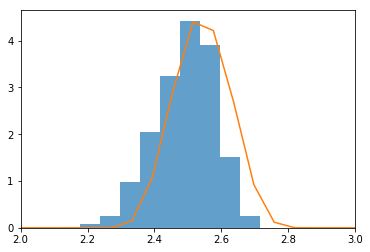

In [18]:
log_Enu = 5.0 # Gev
log_Edep = np.linspace(1.0, 7.0, 100)

prob = []
for E in log_Edep:
    p = 10**pdf_spline(log_Enu, E)[0][0]
    if p < 1e-5:
        p = 0
    prob.append(p)

norm = np.trapz(prob, log10_Edep)
    
# Compare with width of Gaussian currently used in Stan
s = np.random.normal(10**2.5, 0.2 * 10**2.5, 1000)

fig, ax = plt.subplots()
ax.hist(np.log10(s), normed=True, alpha=0.7)
ax.plot(log_Edep, np.array(prob) / norm)
ax.set_xlim(2, 3)

## Sampling from the distribution
Need to have a function which returns normalised dist for a given value of Enu. This is fairly easy in python. Could use spline + np.trapz in Stan to achieve the same?

In [14]:
def my_trapz(y_values, x_values):
    N = len(x_values)
    
    I = []
    for i in range(N-1):
        integ = 0.5 * (x_values[i+1] - x_values[i]) * (y_values[i]+y_values[i+1])
        I.append(integ)
        
    return sum(I)

def sample_Edet(Enu):
    log10_Enu = np.log10(Enu)
    
    # Find normalisation and maximum
    log10_Edet_grid = np.linspace(1.0, 7.0, 100)
    p_grid = [10**pdf_spline(log10_Enu, _)[0][0] for _ in log10_Edet_grid]
    norm = my_trapz(p_grid, log10_Edet_grid)
    p_max = max(np.array(p_grid) / norm)
    
    # Sampling
    accepted = False
    while not accepted:
        log10_Edet = np.random.uniform(1, 7)
        p = np.random.uniform(0, p_max)
        if p <= 10**pdf_spline(log10_Enu, log10_Edet)[0][0] / norm:
            accepted = True
            
    return 10**log10_Edet

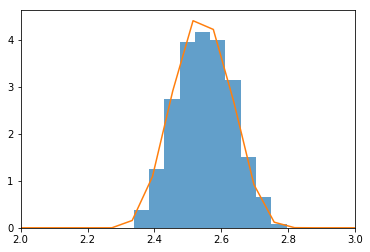

In [15]:
# Compare distribution & samples
log10_Edet_samples = [np.log10(sample_Edet(1e5)) for i in range(1000)]

fig, ax = plt.subplots()
ax.hist(log10_Edet_samples, density=True, alpha=0.7)
ax.plot(log_Edep, np.array(prob) / norm)
ax.set_xlim(2, 3);

## Test stan implementation

In [48]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/test_Eres.stan', 
                                 model_name = 'test_Eres_sim', include_paths = 'stan/')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL test_Eres_sim_5043a858600a9616a2f800e517a4eaad NOW.


In [49]:
# Get input for spline evaluation in Stan
E_p = 1  # spline degree 
E_xknots, E_yknots = energy_conditional.spline.get_knots()
E_xknots = np.unique(E_xknots)
E_yknots = np.unique(E_yknots)
E_Nx = len(E_xknots)+E_p-1 
E_Ny = len(E_yknots)+E_p-1 
E_c = energy_conditional.spline.get_coeffs()
E_c = E_c.reshape(E_Nx, E_Ny)

In [54]:
sim_input = {}
sim_input['N'] = 1000
sim_input['E'] = 1e5
sim_input['E_p'] = E_p
sim_input['E_Lknots_x'] = len(E_xknots)
sim_input['E_Lknots_y'] = len(E_yknots)
sim_input['E_xknots'] = E_xknots
sim_input['E_yknots'] = E_yknots
sim_input['E_c'] = E_c

In [ ]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param")

In [ ]:
# Extract
Edet = simulation.extract(['Edet'])['Edet'][0]

fig, ax = plt.subplots()
ax.hist(np.log10(Edet), density=True, alpha=0.7)
ax.plot(log_Edep, np.array(prob) / norm)
ax.set_xlim(2, 3)